## NIDDK-DF_SD-LLM_EPOCHS1000

### Prediabetes Calculation and labelling
#### Based on HbA1c: 
A normal A1C level is below 5.7%, a level of 5.7% to 6.4% indicates prediabetes, and a level of 6.5% or more indicates diabetes. Within the 5.7% to 6.4% prediabetes range, the higher your A1C, the greater your risk is for developing type 2 diabetes.

https://www.cdc.gov/diabetes/managing/managing-blood-sugar/a1c.html#:~:text=A%20normal%20A1C%20level%20is,for%20developing%20type%202%20diabetes.

#### Based on Glucose level: 
Well, prediabetes means exactly what it sounds like: Your blood sugar levels are high, but not enough to diagnose diabetes. So, you may get diabetes in the future, although you don't have it right now. Doctors study your blood reports before declaring either diabetes or prediabetes based on where your fasting blood sugar count falls:

- Normal: Less than 100 mg/dL
- Prediabetic: 100–125 mg/dL
- Diabetic: Greater than 125 mg/dL

https://www.abbott.in/corpnewsroom/diabetes-care/prediabetic-diet--your-guide-to-blood-sugar-regulation.html#:~:text=Doctors%20study%20your%20blood%20reports,Greater%20than%20125%20mg%2FdL

Link for dataset: https://www.kaggle.com/houcembenmansour/predict-diabetes-based-on-diagnostic-measures

#### Features of dataset
- Cholesterol 	
- glucose 	
- hdl_chol 	
- chol_hdl_ratio 	
- age 	
- gender 	
- height 	
- weight 	
- bmi 	
- systolic_bp 	
- diastolic_bp 	
- waist 	
- hip 	
- waist_hip_ratio 	
- diabetes

<h3>Importing Libraries</h3>

In [2]:
# Execute only once!
import os
import sys
sys.path.append("..")
os.chdir("..")

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import torch
torch.version.cuda

'11.8'

In [4]:
torch.cuda.is_available()

True

In [5]:
import logging
import pandas as pd
import numpy as np
from torch import nn
from torch import optim
from sklearn.preprocessing import StandardScaler
from functools import partial
from utils import set_logging_level
from be_great import GReaT

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

C:\Users\admin\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [6]:
logger = set_logging_level(logging.INFO)

**Loading the Dataset**

In [7]:
#Reading the data and some data are not present as decimals
data=pd.read_csv("C:/Users/admin/Documents/Diabetes_Research/1.Paper/NIDDK-DF_2024/Synthetic_SD-LLM/NIDDK-DF-new-3targets.csv",decimal=",")
df =data.copy()
pd.set_option('display.max_row',df.shape[0])
pd.set_option('display.max_column',df.shape[1]) 
df.head()

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,Outcome
0,193,77,49,3.9,19,1,61,119,22.5,118,70,32,38,0.84,0
1,146,79,41,3.6,19,1,60,135,26.4,108,58,33,40,0.83,0
2,217,75,54,4.0,20,1,67,187,29.3,110,72,40,45,0.89,0
3,226,97,70,3.2,20,1,64,114,19.6,122,64,31,39,0.79,0
4,164,91,67,2.4,20,1,70,141,20.2,122,86,32,39,0.82,0


In [8]:
data.dtypes

cholesterol         int64
glucose             int64
hdl_chol            int64
chol_hdl_ratio     object
age                 int64
gender              int64
height              int64
weight              int64
bmi                object
systolic_bp         int64
diastolic_bp        int64
waist               int64
hip                 int64
waist_hip_ratio    object
Outcome             int64
dtype: object

In [9]:
# Eliminate duplicates
print('There are' , df.duplicated().sum() , 'duplicates')
df.loc[df.duplicated(keep=False),:]
df.drop_duplicates(keep='first',inplace=True)
print('There is now' , df.shape[0] , 'rows')
print('There is now' , df.shape[1] , 'columns')

There are 0 duplicates
There is now 390 rows
There is now 15 columns


In [10]:
df['Outcome'].value_counts(normalize=True)

Outcome
0    0.715385
1    0.153846
2    0.130769
Name: proportion, dtype: float64

In [11]:
df.shape

(390, 15)

In [12]:
df_old = df

#### Data labelling!
- Glucose >125mg/dl is known as diabetes,
- Glucose 125mg/dl to 100mg/dl is prediabetes, while Glucose< 100mg/dl is for normal patients
- Some rows given are complex

#### Create GReaT Model

In [13]:
great = GReaT("distilgpt2",                  # Name of the large language model used (see HuggingFace for more options)
              epochs=1000,                   # Number of epochs to train
              save_steps=2000,               # Save model weights every x steps
              logging_steps=1000,             # Log the loss and learning rate every x steps
              experiment_dir="D:/Synthetic_Data_ESJ/trainer_diab_2024", # Name of the directory where all intermediate steps are saved
              batch_size=16,                 # Batch Size
              #lr_scheduler_type="constant", # Specify the learning rate scheduler 
              #learning_rate=5e-5            # Set the inital learning rate
             )

#### Start Training

In [14]:
trainer = great.fit(df)

2024-05-06 20:51:14,942 - INFO - Convert data into HuggingFace dataset object... (great.py:153)
2024-05-06 20:51:14,971 - INFO - Create GReaT Trainer... (great.py:158)
2024-05-06 20:51:15,258 - INFO - Start training... (great.py:174)
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
1000,0.967100
2000,0.864100
3000,0.833700
4000,0.801900
5000,0.755000
6000,0.694400
7000,0.639400
8000,0.595400
9000,0.561900
10000,0.536600


In [15]:
loss_hist = trainer.state.log_history.copy()
loss_hist.pop()

{'train_runtime': 2711.5092,
 'train_samples_per_second': 143.831,
 'train_steps_per_second': 9.22,
 'total_flos': 9220460093374464.0,
 'train_loss': 0.5684088952636719,
 'epoch': 1000.0,
 'step': 25000}

In [16]:
loss = [x["loss"] for x in loss_hist]
epochs = [x["epoch"] for x in loss_hist]

In [17]:
loss = [x["loss"] for x in loss_hist]
epochs = [x["epoch"] for x in loss_hist]

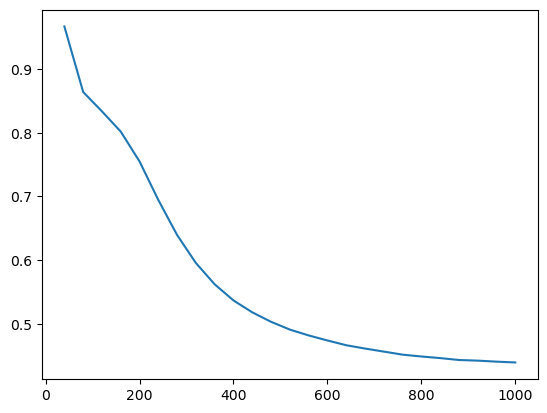

In [18]:
plt.plot(epochs, loss)

In [19]:
great.save("D:/Synthetic_Data_ESJ/Diab_syn_2024")

C:\Users\admin\anaconda3\envs\Paper1\lib\site-packages\be_great\great.py:430: UserWarning: Directory D:/Synthetic_Data_ESJ/Diab_syn_2024 already exists and is overwritten now.
  warnings.warn(f"Directory {path} already exists and is overwritten now.")


#### Generate Samples

In [20]:
n_samples=500

In [21]:
samples = great.sample(n_samples, k=50)

535it [00:08, 63.43it/s]                         


In [22]:
samples.head()

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,Outcome
0,179.0,85.0,52.0,3.4,32.0,0.0,65.0,179.0,31.3,140.0,96.0,38.0,46.0,0.86,2.0
1,236.0,105.0,108.0,2.5,20.0,1.0,61.0,113.0,22.3,132.0,90.0,31.0,39.0,0.84,2.0
2,179.0,87.0,52.0,3.0,39.0,1.0,61.0,170.0,28.1,140.0,96.0,34.0,42.0,0.79,0.0
3,219.0,71.0,52.0,5.7,72.0,0.0,72.0,170.0,23.1,145.0,120.0,34.0,39.0,0.82,0.0
4,212.0,81.0,36.0,5.1,33.0,1.0,64.0,200.0,33.5,110.0,70.0,36.0,45.0,0.82,0.0


In [23]:
samples_custom = great.sample(n_samples, k=50, start_col="Outcome",start_col_dist={"2": 0.5, "1": 0.5, "0": 0})

536it [00:08, 63.37it/s]                         


In [24]:
samples_custom.shape

(500, 15)

In [25]:
df_final = samples_custom

In [26]:
df_final[df_final==np.inf]=np.nan

In [27]:
df_final = df_final.dropna()

In [28]:
df_final['Outcome'] = df_final['Outcome'].astype(int)

In [29]:
#df_final = df_final.rename({'diabetes':'Outcome'}, axis=1)
df_final.to_csv("NIDDK-DF_SD-LLM_onlysyn2024.csv")

In [32]:
df_diab = pd.concat([df_old, samples_custom], ignore_index=True)

In [33]:
df_diab[df_diab==np.inf]=np.nan

In [34]:
df_diab = df_diab.dropna()

In [35]:
df_diab['Outcome'] = df_diab['Outcome'].astype(int)

In [36]:
df_diab = df_diab.rename({'diabetes':'Outcome'}, axis=1)
df_diab.to_csv("NIDDK-DF_SD-LLM_2024.csv")

In [37]:
df_diab['Outcome'].value_counts(normalize=True)

Outcome
1    0.353933
2    0.332584
0    0.313483
Name: proportion, dtype: float64

Check these links:
https://github.com/kathrinse/be_great/blob/main/examples/Example_Iris.ipynb

Citing

@article{borisov2022language,
  title={Language Models are Realistic Tabular Data Generators},
  author={Borisov, Vadim and Se{\ss}ler, Kathrin and Leemann, Tobias and Pawelczyk, Martin and Kasneci, Gjergji},
  journal={arXiv preprint arXiv:2210.06280},
  year={2022}
}